In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.preprocessing import image_dataset_from_directory
import numpy as np
import matplotlib.pyplot as plt
import cv2

In [3]:
from sklearn.model_selection import train_test_split

In [4]:
train_data = '/content/drive/MyDrive/workspace/AI_project_data_set/dataset/train/'
valid_data = '/content/drive/MyDrive/workspace/AI_project_data_set/dataset/valid/'

In [5]:
image_size = (224, 224)
batch_size = 16

In [6]:
train_set = image_dataset_from_directory(
    train_data,
    shuffle=True,
    image_size=(224, 224),
    batch_size=batch_size
    )
valid_set = image_dataset_from_directory(
    valid_data,
    shuffle=True,
    image_size=(224, 224),
    batch_size=batch_size
)
labels = train_set.class_names
print(labels)

Found 494 files belonging to 2 classes.
Found 140 files belonging to 2 classes.
['non_died', 'you_died']


In [7]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_set = train_set.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
valid_set = valid_set.cache().prefetch(buffer_size=AUTOTUNE)

In [8]:
data_augmentation = tf.keras.Sequential(
  [
    tf.keras.layers.experimental.preprocessing.RandomFlip(
        "horizontal",
        input_shape=(224, 224, 3)
        ),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.1),
    tf.keras.layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

In [9]:
normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)

normalized_ds = train_set.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0021736296 1.0


In [26]:
num_classes = 2
model = tf.keras.Sequential([
    data_augmentation,
    tf.keras.layers.experimental.preprocessing.Rescaling(1./255),
    tf.keras.layers.Conv2D(224, (3, 3), padding='same', activation='relu'),
    tf.keras.layers.Conv2D(224, (3, 3), padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(112, (3, 3), padding='same', activation='relu'),
    tf.keras.layers.Conv2D(112, (3, 3), padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(56, (3, 3), padding='same', activation='relu'),
    tf.keras.layers.Conv2D(56, (3, 3), padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(28, (3, 3), padding='same', activation='relu'),
    tf.keras.layers.Conv2D(28, (3, 3), padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(14, (3, 3), padding='same', activation='relu'),
    tf.keras.layers.Conv2D(14, (3, 3), padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(16, activation='relu'),
    # tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(2, activation='sigmoid'),
    # layers.Dense(num_classes)
])

In [27]:
model.compile(
    optimizer='RMSprop',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
    )

In [28]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 224, 224, 224)     6272      
                                                                 
 conv2d_1 (Conv2D)           (None, 224, 224, 224)     451808    
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 224)    0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 112, 112, 112)     225904    
                                                      

In [10]:
model = tf.keras.Sequential([
    data_augmentation,
    tf.keras.layers.experimental.preprocessing.Rescaling(1./255),
    tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(2, activation='sigmoid'),
    # layers.Dense(num_classes)
])

model.compile(optimizer='RMSprop',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 224, 224, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 32)      9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 32)       0         
 2D)                                                  

In [11]:
callbacks = [
             tf.keras.callbacks.ModelCheckpoint("save_at_{epoch}.h5"),
             ]

epochs=5

history = model.fit(
    train_set,
    validation_data=valid_set,
    callbacks=callbacks,
    epochs=epochs
)

Epoch 1/5


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


31/31 [==============================] - 41s 977ms/step - loss: 0.8064 - accuracy: 0.5587 - val_loss: 0.4541 - val_accuracy: 0.7929
Epoch 2/5
31/31 [==============================] - 1s 30ms/step - loss: 0.4932 - accuracy: 0.7652 - val_loss: 0.2934 - val_accuracy: 0.8714
Epoch 3/5
31/31 [==============================] - 1s 30ms/step - loss: 0.3436 - accuracy: 0.8745 - val_loss: 0.2984 - val_accuracy: 0.9214
Epoch 4/5
31/31 [==============================] - 1s 29ms/step - loss: 0.2211 - accuracy: 0.9109 - val_loss: 0.7509 - val_accuracy: 0.8000
Epoch 5/5
31/31 [==============================] - 1s 29ms/step - loss: 0.1828 - accuracy: 0.9393 - val_loss: 0.3418 - val_accuracy: 0.8714


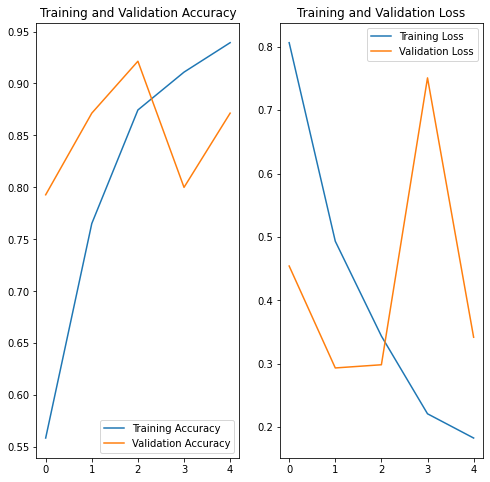

In [12]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

[0.978973   0.02565311]


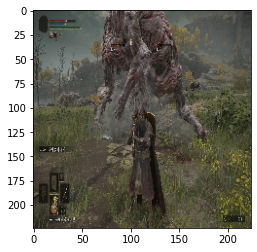

In [24]:
img = tf.keras.preprocessing.image.load_img(
    '/content/drive/MyDrive/workspace/AI_project_data_set/dataset/test/non_died/20220307171045_1.jpg',
    target_size=image_size
)
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

predictions = model.predict(img_array)
score = predictions[0]
print(score)
plt.imshow(img)

[0.11319669 0.95256746]


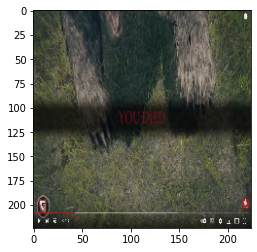

In [25]:
img = tf.keras.preprocessing.image.load_img(
    '/content/drive/MyDrive/workspace/AI_project_data_set/dataset/test/you_died/35.jpg',
    target_size=image_size
)
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

predictions = model.predict(img_array)
score = predictions[0]
print(score)
plt.imshow(img)

In [26]:
model.save('/content/drive/MyDrive/workspace/AI_project_data_set/dataset/save_model')
model.save('/content/drive/MyDrive/workspace/AI_project_data_set/dataset/save_model.h5', save_format='h5')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/workspace/AI_project_data_set/dataset/save_model/assets
